In [ ]:
import os
import time
import copy
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, average_precision_score, log_loss, brier_score_loss

from utils_data import split_dataset
from utils_metrics import brier_loss, plot_confusion_matrix, plot_precision_recall_curve, evaluate_model

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# Example usage
if not Path("skin_cancer_dataset/train").exists():
    split_dataset("skin_cancer_dataset", train_ratio=0.7, val_ratio=0.2, image_ext="*.jpg")

In [7]:
data_dir = 'skin_cancer_dataset'

# Data augmentation for train; only normalization for val & calibration
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'calibration': transforms.Compose([  # Same as val, no augmentation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets including calibration
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'calibration']}

# Create dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True if x == 'train' else False, num_workers=4)
              for x in ['train', 'val', 'calibration']}

# Get dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'calibration']}

# Class names
class_names = image_datasets['train'].classes
class_names

['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

In [11]:
model = models.vgg16(pretrained=True)

# Freeze all the parameters
# for param in model.parameters():
#     param.requires_grad = False

# Freeze feature extractor
for param in model.features.parameters():
    param.requires_grad = False  

# Train classifier
for param in model.classifier.parameters():
    param.requires_grad = True  

# Modify the classifier
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 7)  
# model.classifier[3] = nn.Linear(4096, 256)
# model.classifier[6] = nn.Linear(256, 2)


model = model.to(device)
# model

In [12]:
model.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [13]:
criterion = nn.CrossEntropyLoss()

LAYERS = model.classifier[6]
LEARNING_RATE = 0.001

# Only parameters of the final layer are being optimized
# optimizer = optim.SGD(model.classifier[6].parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(LAYERS.parameters(), lr=LEARNING_RATE)

LAYERS

Linear(in_features=4096, out_features=7, bias=True)

In [27]:
# def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=25):
#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_f1 = 0.0  # Track best F1-score

#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch}/{num_epochs - 1}')
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluation mode

#             running_loss = 0.0
#             running_corrects = 0
#             all_labels = []
#             all_preds = []

#             # Iterate over data
#             iterate_dataloader = tqdm(dataloaders[phase])
#             # for inputs, labels in iterate_dataloader:
#             for inputs, labels in itertools.islice(iterate_dataloader, 5):
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # Zero the parameter gradients
#                 optimizer.zero_grad()

#                 # Forward pass
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     # Backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # Store labels and predictions for F1-score
#                 all_labels.extend(labels.cpu().numpy())
#                 all_preds.extend(preds.cpu().numpy())

#                 # Statistics
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]

#             # Compute F1-score
#             epoch_f1 = f1_score(all_labels, all_preds, average='macro')

#             print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')

#             # Save model if it has the best F1-score
#             if phase == 'val' and epoch_f1 > best_f1:
#                 best_f1 = epoch_f1
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     time_elapsed = time.time() - since
#     print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
#     print(f'Best val F1: {best_f1:.4f}')

#     # Load best model weights
#     model.load_state_dict(best_model_wts)
#     return model

import itertools
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0  # Track best F1-score

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            # Iterate over data with tqdm progress bar
            iterate_dataloader = tqdm(dataloaders[phase], desc=f"{phase.upper()} Epoch {epoch+1}/{num_epochs}")

            # for inputs, labels in iterate_dataloader:
            for inputs, labels in itertools.islice(iterate_dataloader, 5):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # Get class with highest probability
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Store labels and predictions for F1-score computation
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Compute Macro F1-score (equal weight for all classes)
            epoch_f1 = f1_score(all_labels, all_preds, average='macro')

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')

            # Save model if it has the best F1-score
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val F1: {best_f1:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [28]:
model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=1) # num_epochs=25 

Epoch 1/1
----------


TRAIN Epoch 1/1:   2%|▏         | 4/220 [00:34<30:45,  8.54s/it]  


train Loss: 0.0311 Acc: 0.0140 F1: 0.1210


VAL Epoch 1/1:   6%|▋         | 4/63 [00:32<08:04,  8.21s/it]

val Loss: 0.2750 Acc: 0.0000 F1: 0.0000

Training complete in 1m 7s
Best val F1: 0.0000


In [32]:
for x,_ in dataloaders["val"]:
    print(model(x))
    break

tensor([[-4.3311, -0.9544,  0.5879, -3.9701,  0.1643,  1.5642, -2.5704],
        [-3.3822, -1.3192,  0.9101, -3.3468, -0.6820,  1.6317, -2.6995],
        [-3.8056, -1.1822,  0.2462, -3.3246, -0.6910,  1.7980, -2.1085],
        [-2.9311, -1.0461,  0.6535, -2.9973, -0.1766,  1.6137, -2.4721],
        [-4.0961, -1.1175,  0.5054, -3.8349,  0.0277,  1.7518, -2.8774],
        [-3.5946, -1.0824,  0.6329, -3.1869,  0.0441,  1.4411, -2.5527],
        [-3.4342, -0.7712,  0.5114, -2.9192, -0.0804,  1.3365, -2.2069],
        [-4.5729, -1.5435,  0.3203, -4.3791, -0.6611,  2.2569, -3.0488],
        [-2.5140, -1.0540,  0.5441, -2.8149, -0.4193,  1.5064, -1.9598],
        [-3.7520, -0.8754,  0.6951, -3.6219, -0.3645,  1.5028, -2.7029],
        [-3.6761, -0.8316,  0.5740, -3.4484, -0.7015,  1.5581, -2.3419],
        [-2.9170, -1.0981,  0.4662, -2.9885, -0.2839,  1.7599, -2.1791],
        [-3.2702, -0.6654,  0.2590, -3.1921, -0.5648,  1.5850, -2.4114],
        [-4.8237, -1.6300,  0.4989, -4.2716, -0.340

In [35]:
import torch
import torch.nn.functional as F

def predict_proba(model, dataloader, device):
    all_probs = []
    all_labels = []

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations
        # for inputs, labels in tqdm(dataloader):
        for inputs, labels in tqdm(itertools.islice(dataloader, 5)):
            inputs = inputs.to(device)  # Move input to GPU/CPU
            outputs = model(inputs)  # Get raw model outputs (logits)

            # Apply Softmax to get probabilities for all classes
            probs = F.softmax(outputs, dim=1)  # Keep all class probabilities

            all_probs.append(probs.cpu())  # Move to CPU and store
            all_labels.append(labels.cpu())

    return torch.cat(all_labels), torch.cat(all_probs)  # Concatenate all probabilities into a single tensor

# Run inference on validation dataset
val_labels, val_probs = predict_proba(model, dataloaders['val'], device)
cal_labels, cal_probs = predict_proba(model, dataloaders['calibration'], device)

# Print shape of output tensor
print("Validation Probabilities Shape:", val_probs.shape)  # Should match (num_samples, num_classes)
print("Validation Labels:")
print(val_labels)
print("Validation Probabilities:")
print(val_probs)  # Display tensor of probabilities


5it [00:18,  3.74s/it]
5it [00:23,  4.65s/it]

Validation Probabilities Shape: torch.Size([160, 7])
Validation Labels:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Validation Probabilities:
tensor([[0.0016, 0.0467, 0.2182,  ..., 0.1428, 0.5792, 0.0093],
        [0.0040, 0.0314, 0.2921,  ..., 0.0594, 0.6010, 0.0079],
        [0.0027, 0.0369, 0.1540,  ..., 0.0603, 0.7271, 0.0146],
        ...,
        [0.0029, 0.0454, 0.2705,  ..., 0.0703, 0.6031, 0.0052],
        [0.0018, 0.0391, 0.2398,  ..., 0.0945, 0.6085, 0.0133],
        [0.0007, 0.0217, 0.2010,

In [36]:
evaluate_model(val_labels, val_probs)

# Base Model Evaluation


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

In [15]:
# Fit logistic regression for Platt Scaling
platt_scaler = LogisticRegression()
platt_scaler.fit(cal_probs.reshape(-1, 1), cal_labels)

# Get calibrated probabilities
platt_probs = platt_scaler.predict_proba(val_probs.reshape(-1, 1))[:, 1]

# Base Model Evaluation
Accuracy: 0.8888888888888888
F1 Score: 0.92
Average Precision Score: 0.9597817142126603


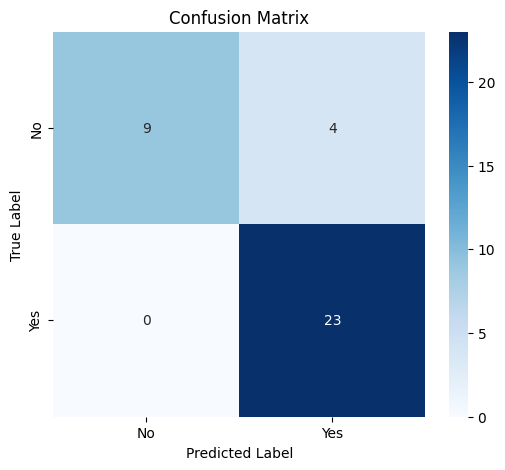

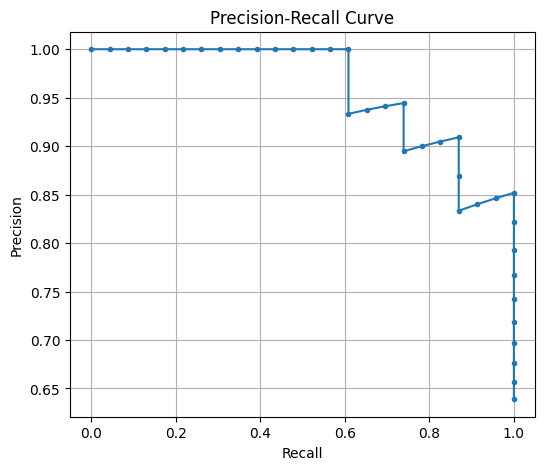


# Calibration Evaluation
Log Loss: 0.4819057163709548
Brier Loss: 0.15198911582256325


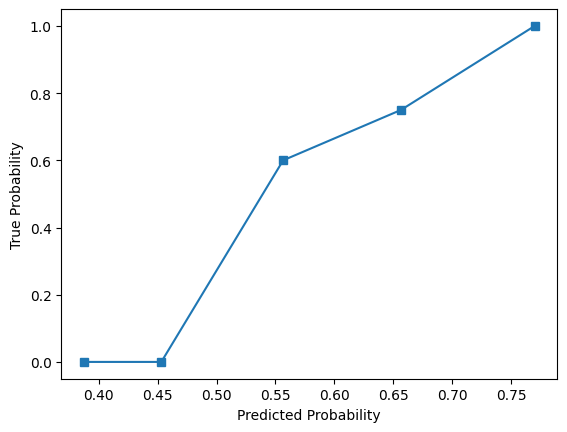

In [17]:
evaluate_model(val_labels, platt_probs)

In [19]:
# Fit isotonic regression
iso_reg = IsotonicRegression(out_of_bounds="clip")  # Clip ensures values remain in valid probability range
iso_reg.fit(cal_probs, cal_labels)

# Get calibrated probabilities
iso_probs = iso_reg.predict(val_probs)

# Base Model Evaluation
Accuracy: 0.8888888888888888
F1 Score: 0.92
Average Precision Score: 0.955915506299138


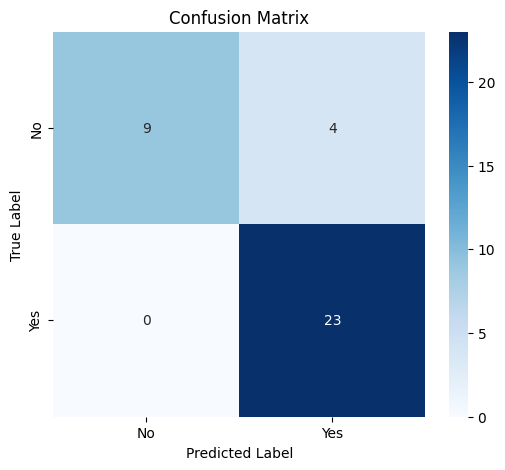

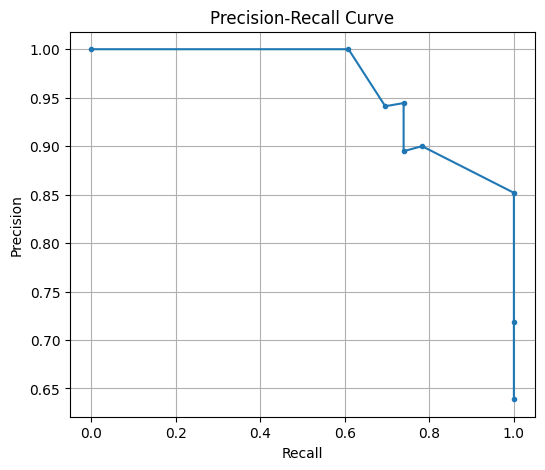


# Calibration Evaluation
Log Loss: 0.264501250383166
Brier Loss: 0.08634770837590006


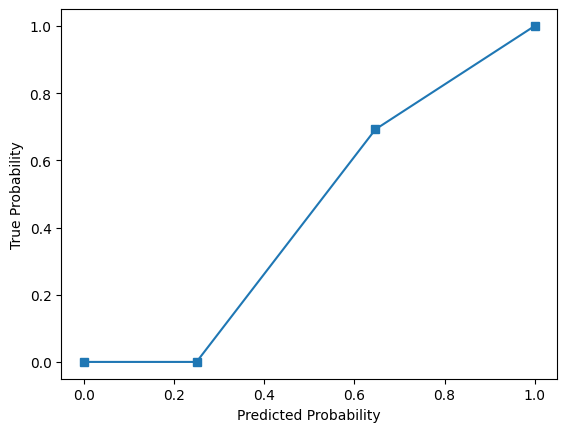

In [20]:
evaluate_model(val_labels, iso_probs)